In [23]:
import os
import sys
import numpy as np
import vaex
from matplotlib import pyplot as plt

In [10]:


def readNEXUS(densityFile,gridsize,vel=False,velFile=None,ddir=""):
    #This function will read the files generated by runNEXUS and make them into numpy arrays
    #It can also read DTFE velocity files as an extra option
    #The order is as follows, it returns:
    #Densityfield, NEXUS_nodes, NEXUS_filaments, NEXUS_walls, Velocity (optional)
    #The NEXUS arrays can then be used for contours or converted into boolean arrays
    #Where all cells > 0 are part of the corresponding structure
    #Voids are located where the other three components are all 0 
    shape = (gridsize,gridsize,gridsize)
    denfield = np.fromfile(densityFile,dtype=np.float32)
    denfield = np.reshape(denfield[262:-2],shape)
    MMFn = np.fromfile(f"{ddir}node_clean.MMF",dtype=np.int16)
    MMFn = np.reshape(MMFn[527:-1],shape)
    MMFf = np.fromfile(f"{ddir}fila_clean.MMF",dtype=np.int16)
    MMFf = np.reshape(MMFf[527:-1],shape)
    MMFw = np.fromfile(f"{ddir}wall_clean.MMF",dtype=np.int16)
    MMFw = np.reshape(MMFw[527:-1],shape)
    #Correct for the z-axis missallignment of the density field wrt NEXUS
    def maxmean(densf,MMFfila,axisn,ran):
        k = np.zeros(ran)
        for i in range(ran):
            k[i] = np.mean(np.roll(densf,i,axis=axisn)[MMFfila>0])
        return np.argmax(k)
    
    shift = maxmean(denfield,MMFf,2,gridsize)
    denfield = np.roll(denfield,shift,axis=2)
    if vel==True:
        velo = np.fromfile(velFile,dtype=np.float32)
        k = np.reshape(velo,(gridsize,gridsize,gridsize,3))
        k = np.roll(k,shift,axis=2)
        return denfield, MMFn, MMFf, MMFw, k
    else:
        return denfield, MMFn, MMFf, MMFw
    


In [18]:
ProjDir = "/Users/users/spirov/ThesisProject"

binDir = ProjDir + "/Nexus/NEXUS_1.0/bin"

dataDir = f"{ProjDir}/Data/Densities/"
ddir = dataDir+"NexOuts/"

In [19]:
name = "RedshiftSpace"
n=512

tempfile = f"{dataDir}{name}.dat"

denfield, MMFn, MMFf, MMFw = readNEXUS(tempfile,n,vel=False,velFile=None,ddir=ddir)

physicalPackage = (denfield,MMFn,MMFf,MMFw)

In [148]:
h=0.704
L = 75000*h

def snapToGrid(r):
    nr=r+L/2 # add to all dimentions 
    nr*= (n+1)/L # convert to grid
    return np.round(nr)

def generateMask(r, Nex):
    """
    Generates a mask array based on the positions in r and the values in Nex.
    
    Parameters:
    r (array-like): A list of vectors, each containing x, y, and z positions.
    Nex (3D array): A 3D numpy array where each dimension corresponds to x, y, or z. Values are either 1 or 0.
    
    Returns:
    mask (array): An array of 1s and 0s corresponding to whether each vector in r lies on a 1 or 0 in Nex.
    """
    # Convert r to a numpy array for easier manipulation
    r = np.array(r)
    
    # Ensure r is of shape (n, 3)
    if r.shape[1] != 3:
        raise ValueError("Each vector in r must have exactly 3 coordinates (x, y, z)")
    
    # Extract x, y, z coordinates from r
    x_coords = r[:, 0].astype(int)
    y_coords = r[:, 1].astype(int)
    z_coords = r[:, 2].astype(int)
    
    # Ensure the coordinates are within the bounds of Nex
    
    if (x_coords >= Nex.shape[0]).any() or (y_coords >= Nex.shape[1]).any() or (z_coords >= Nex.shape[2]).any():
        
        raise ValueError("Some coordinates in r are out of bounds of the Nex array")
    
    # Generate the mask by indexing into Nex
    mask = Nex[x_coords, y_coords, z_coords]
    
    return mask



In [128]:
dataPath = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Testing/"
fil = dataPath + os.listdir(dataPath)[0]

df = vaex.open(fil)

In [139]:
df['X'] = df.CZ * np.sin(df.Th)*np.cos(df.Fi)
df['Y'] = df.CZ * np.sin(df.Th)*np.sin(df.Fi)
df['Z'] = df.CZ * np.cos(df.Th)

In [140]:
x = df.X.values
y= df.Y.values
z=df.Z.values

In [188]:
r = np.array((x,y,z)).T

r= r[(r[:,0]>-L/2)*(r[:,1]>-L/2)*(r[:,2]>-L/2)*(r[:,0]<L/2)*(r[:,1]<L/2)*(r[:,2]<L/2)]

(0.0, 512.0)

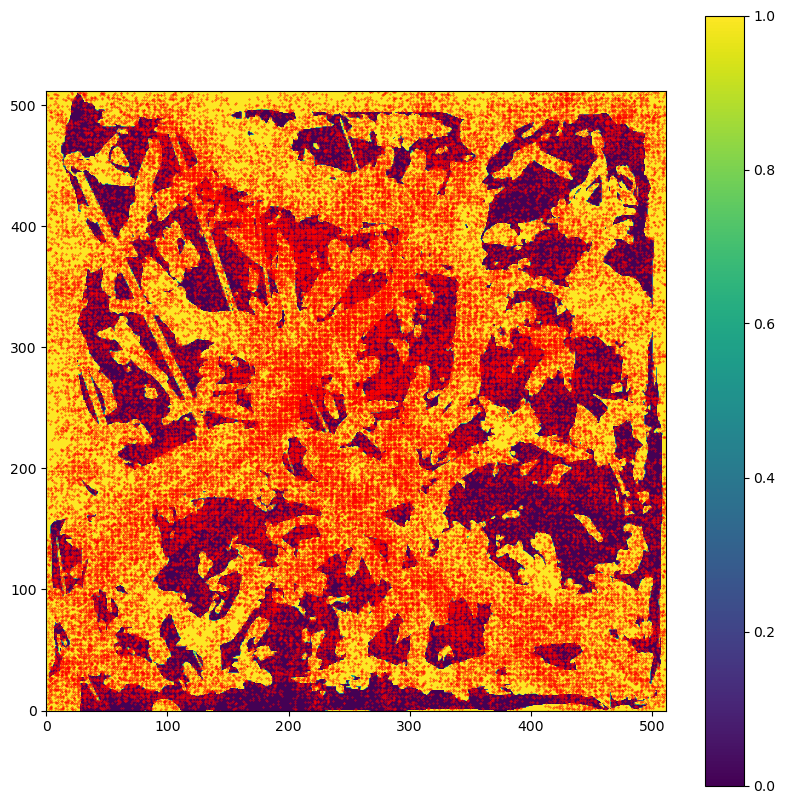

In [191]:
def snapToGrid(r):
    nr=r+L/2 # add to all dimentions 
    nr*= (n-1)/L # convert to grid
    return np.round(nr)
sR = snapToGrid(r)


plt.figure(figsize=(10,10))
plt.imshow(MMFf[:,:].sum(2),vmin=0,vmax=1,origin = 'lower')
plt.colorbar()
plt.scatter(sR[:,0],sR[:,1],s=0.1,c='r')

plt.ylim(0,n)
plt.xlim(0,n)

In [200]:
maskMMFf = np.where(MMFf>0,1,0)

mask = generateMask(sR,maskMMFf)
nR = sR[mask==1]

In [201]:
len(nR)

2690

(0.0, 512.0)

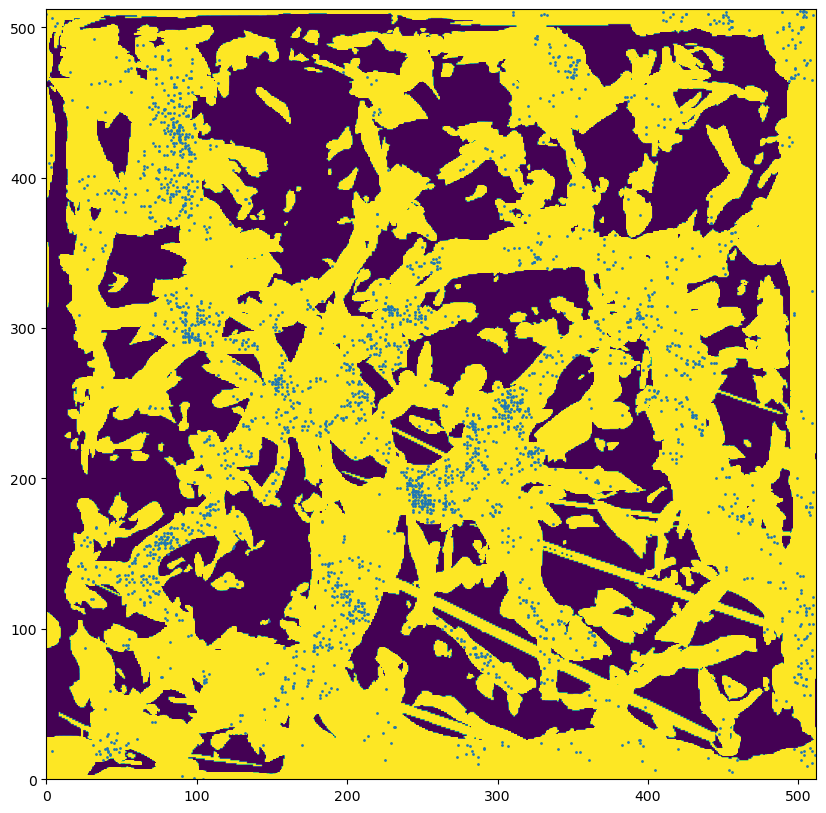

In [214]:
plt.figure(figsize=(10,10))
plt.imshow(MMFf[:,:,:].sum(2).T,vmax=1,vmin=0,origin='lower')
#plt.colorbar()
plt.scatter(nR[:,0],nR[:,1],s=1)
plt.ylim(0,n)
plt.xlim(0,n)

Text(0.5, 0.92, 'Subhalos Within Filament')

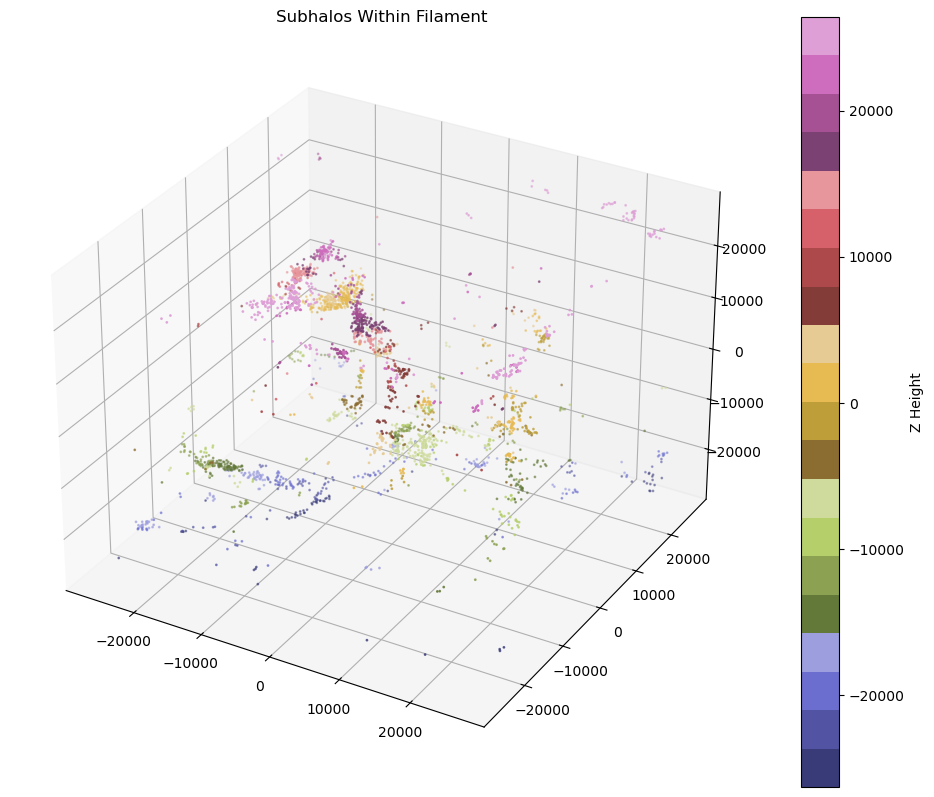

In [239]:
plt.figure(figsize=(12,10))
finR = nR*L/(n-1) - L/2
ax = plt.subplot(projection="3d")
sc = ax.scatter(finR[:,0],finR[:,1],finR[:,2],s=1,cmap="tab20b",c=finR[:,2])
cb=plt.colorbar(sc)
cb.set_label("Z Height")
plt.title("Subhalos Within Filament")
